In [1]:
# modules
import pandas as pd
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
# scrap the Wiki-page and construct the dataframe
link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
data=pd.read_html(link, header=0)[0]

## Preprocessing

In [3]:
# remove entries with no assigned borough
index2drop=data[data.Borough=='Not assigned'].index
data.drop(data.index[index2drop], inplace=True)
# see how many postal-codes correspond to each Neighborhood
neighborhoods=data.groupby('Neighborhood')['Postal Code'].count()
# find the 'deviant' neighborhoods (more than one postal-code per neighborhood)  
deviant_indices=np.where(neighborhoods.values != 1)[0]
# observe the neighborhoods with multiple postal-codes
print(f'The neighborhoods with multiple codes are: {neighborhoods[deviant_indices].index.tolist()}')
# See if there are multiple listings for a postal-code
if np.mean(data['Postal Code'].value_counts().tolist())==1: #mean==1--> 1-1 mapping
    print('No multiple listings - no further action needed')
# Check if there are cells where the Borough is the same with the Neighborhood
if not data[data.Borough==data.Neighborhood].size > 0: # empty array --> No matching
    print('There are not any cells where the Borough is the same with the Neighborhood') 


The neighborhoods with multiple codes are: ['Don Mills', 'Downsview', 'Willowdale']
No multiple listings - no further action needed
There are not any cells where the Borough is the same with the Neighborhood


In [4]:
# check the shape of the dataframe
print(f'The table has {data.shape[0]} rows and {data.shape[1]} columns')

The table has 103 rows and 3 columns


## Add Coordinates

In [5]:
path2coords= os.path.join('../Data/')
coords=pd.read_csv(os.path.join(path2coords, os.listdir(path2coords)[0]))
# sort the dataframes to match the Postal Codes
data.sort_values('Postal Code', inplace=True)
coords.sort_values('Postal Code',inplace=True)
# make sure there is a size match prior to concatenating
if not data.shape==coords.shape: raise ValueError('mismatch')
data['Latitude']=coords['Latitude']
data['Longitude']=coords['Longitude']


## Explore and cluster the neighborhoods in Toronto

In [6]:
def dataframe_of_interest(data, area='Toronto'):
    '''
    From the original dataframe, construct a dataframe with the areas of interest. 
    The new dataframe does not contain NaN values.
    
    Parameters
    ----------
    data : Pandas Dataframe
        The dataframe that contains all areas.
    area : String
        The area you want to investigate. 
        DEFAULT: 'Toronto'

    Returns
    -------
    parsed_df : Pandas Dataframe
        The preprocessed dataframe that contains only the areas of interest.
        DEFAULT: All areas that contain the word 'Toronto'.

    '''
    # Neighborhoods of Interest (noi)
    noi=[s for s in data.Borough.unique().tolist() if area in s]
    # construct the target dataframe
    target=data.loc[data.Borough.isin(noi)]
    # we are missing some coordinate values. Keep only the non-NaNs
    parsed_df = target[target.Latitude.notna()]
    
    return parsed_df


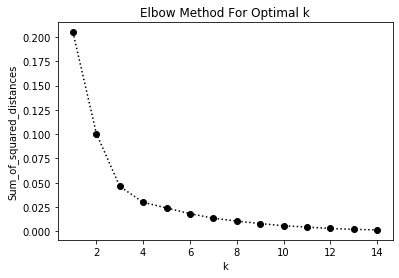

Using the elbow method, we see achieve the best clustering using 4 distinct clusters


In [7]:
area='Toronto'
# get dataframe of interest (doi)
doi=dataframe_of_interest(data,area)
# We will use only the coordinates for clustering 
parsed_df=doi[['Latitude','Longitude']]
# Find the optimal k
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k) # run model with given k
    km = km.fit(parsed_df) # fit the model
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'ko:');plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances');plt.title('Elbow Method For Optimal k')
plt.show()

print('Using the elbow method, we see achieve the best clustering using 4 distinct clusters')

Text(0.5, 1.0, 'Clustered neighborhoods coordinates. Area: Toronto')

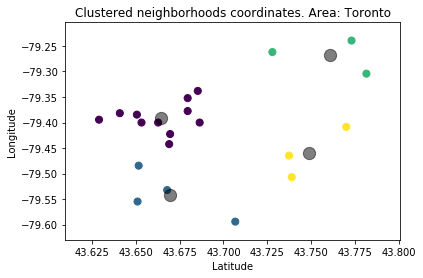

In [8]:
# Run Kmeans with the optimal k and visualize the clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(parsed_df)
y_kmeans = kmeans.predict(parsed_df)

plt.scatter(parsed_df.Latitude, parsed_df.Longitude, c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=150, alpha=0.5);
plt.xlabel('Latitude'); plt.ylabel('Longitude')
plt.title(f'Clustered neighborhoods coordinates. Area: {area}')


In [9]:
kclusters=4
# create map
map_clusters = folium.Map(location=[parsed_df.Latitude.tolist(), parsed_df.Longitude.tolist()], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

parsed_df.insert(0, 'Cluster Labels', kmeans.labels_)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(parsed_df['Latitude'], parsed_df['Longitude'], doi['Neighborhood'], parsed_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters